# Load Sparsity from Checkpoints and Compare

In [1]:
#%matplotlib notebook
import os
import numpy as np;
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.layers as c_layers
import seaborn as sns

c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:5

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
folder_name = '3999_16.100'
path = './Results/TowerTraining/Recordings/Standard/'+folder_name+'/'
figure_path = './Results/TowerTraining/Figures/NNFiguresSameOpt/experimental/'
Cpath = './Results/TowerTraining/Recordings/Standard/gradients/runVars/'

obs = np.load(path+'visobs.npy', mmap_mode='r')
ginisC = np.load(Cpath+'ginisC.npy')

In [3]:
def encsFromCkpts(ckpts_to_use,ckpt_path):
    allEnc = np.zeros((ckpts_to_use.shape[0],obs.shape[0],256))
    for i in range(ckpts_to_use.shape[0]):
        ckpt_path_ext = ckpt_path+ckpts_to_use[i]+'0000.cptk'
        
        tf.reset_default_graph()

        def swish(input_activation):
            """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
            return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

        o_size_h = 168
        o_size_w = 168
        num_layers = 2
        h_size = 256
        h_size_vec = 256

        visual_in = tf.placeholder(shape=[None, o_size_h, o_size_w, 3], dtype=tf.float32,name="visual_observation_0")

        def create_vector_observation_encoder(observation_input, h_size, activation, num_layers, scope,reuse):
            with tf.variable_scope(scope):
                hidden_vec = observation_input
                for i in range(num_layers):
                    hidden_vec = tf.layers.dense(hidden_vec, h_size, activation=activation, reuse=reuse,name="hidden_{}".format(i),kernel_initializer=c_layers.variance_scaling_initializer(1.0))
            return hidden_vec

        def create_visual_observation_encoder(image_input, h_size, activation, num_layers, scope,reuse):
            with tf.variable_scope(scope):
                conv1 = tf.layers.conv2d(image_input, 16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, reuse=reuse, name="conv_1")
                conv2 = tf.layers.conv2d(conv1, 32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, reuse=reuse, name="conv_2")
                hidden_vis = c_layers.flatten(conv2)

            with tf.variable_scope(scope + '/' + 'flat_encoding'):
                hidden_flat = create_vector_observation_encoder(hidden_vis, h_size, activation,num_layers, scope, reuse)
            return hidden_flat


        visual_encoders = []
        hidden_state, hidden_visual = None, None

        encoded_visual = create_visual_observation_encoder(visual_in,h_size,swish,num_layers,"main_graph_0_encoder0", False)
        visual_encoders.append(encoded_visual)
        hidden_visual = tf.concat(visual_encoders, axis=1)

        sess = tf.Session()
        init = tf.global_variables_initializer()
        sess.run(init)

        saver = tf.train.Saver()
        if int(ckpts_to_use[i])>0:
            saver.restore(sess, ckpt_path_ext)
        enc = sess.run(hidden_visual, feed_dict={visual_in: obs})
        allEnc[i] = enc
    return allEnc

In [4]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten() #all values are treated equally, arrays must be 1d
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

def getSparsityStats(encs,ckpts):
    numCkpt = encs.shape[0]
    NNever = np.zeros(numCkpt)
    AvgPerFrame = np.zeros(numCkpt)
    more40Per = np.zeros(numCkpt)
    mostAct = np.zeros(numCkpt)
    ginis = np.zeros(numCkpt)
    for i in range(numCkpt):
        perAct = np.sum((encs[i])>0,axis=0)/encs[i].shape[0]*100
        NNever[i] = np.sum(perAct==0)
        AvgPerFrame[i] = np.mean(np.sum(encs[i]>0,axis=1))
        more40Per[i] = np.sum(perAct>40)
        mostAct[i] = np.max(perAct)
        ginis[i] = np.round(gini(np.abs(encs[i])),3)
    allStats = {'perAct': perAct,'NNever': NNever,'AvgPerFrame':AvgPerFrame,
               'more40Per': more40Per, 'mostAct': mostAct, 'ginis': ginis,'ckpts': ckpts}
    return allStats

def ckptsToM(ckpts):
    ckptFloats = np.zeros(ckpts.shape[0])
    ckptsM = []
    for i in range(ckpts.shape[0]):
        ckptFloats[i] = float(ckpts[i])/100
        ckptsM.append(str(float(ckpts[i])/100))
    return ckptFloats, np.array(ckptsM)

def plotStats(stats, title='', save=False):
    plt.figure(figsize=(10,5))
    ckptFloat, ckptLabel = ckptsToM(stats['ckpts'])
    plt.plot(ckptFloat,stats['NNever']/256*100,lw=5)
    plt.plot(ckptFloat,stats['AvgPerFrame']/256*100,lw=5)
    plt.plot(ckptFloat,stats['more40Per']/256*100,lw=5)
    plt.plot(ckptFloat,stats['mostAct'],lw=5)
    plt.plot(ckptFloat,stats['ginis']*100,lw=5)

    plt.xlim([0,np.max(ckptFloat)-1])
    plt.ylim([0,100])
    plt.ylabel('%',fontsize=15)
    plt.xlabel('Number of Steps (million)',fontsize=15)
    #plt.xticks(np.linspace(0,18,19),model_ckpts_M,fontsize=12)
    
    plt.xticks(ckptFloat,ckptLabel,fontsize=12,rotation=90)
    plt.yticks(fontsize=12)
    plt.title(title,fontsize=15)
    plt.legend(['Neurons Never Active','Avg Neurons Active per Frame','Active in >40%','Most Active','Gini Index'])
    if save:
        plt.savefig(figure_path+'sparsityStats_'+title+'.png', bbox_inches='tight', dpi=300)
    else:
        plt.show()
        
def plotStatsBaseline(stats, baseline, title='', save=False):
    plt.figure(figsize=(10,5))
    ckptFloat, ckptLabel = ckptsToM(stats['ckpts'])
    ckptFloatB, ckptLabelB = ckptsToM(baseline['ckpts'])
    plt.plot(ckptFloat,stats['NNever']/256*100,'b--',lw=5)
    plt.plot(ckptFloat,stats['AvgPerFrame']/256*100,'r--',lw=5)
    plt.plot(ckptFloat,stats['more40Per']/256*100,'y--',lw=5)
    plt.plot(ckptFloat,stats['mostAct'],'g--',lw=5)
    plt.plot(ckptFloat,stats['ginis']*100,'m--',lw=5)
    
    plt.plot(ckptFloatB,baseline['NNever']/256*100,'b-',lw=5)
    plt.plot(ckptFloatB,baseline['AvgPerFrame']/256*100,'r-',lw=5)
    plt.plot(ckptFloatB,baseline['more40Per']/256*100,'y-',lw=5)
    plt.plot(ckptFloatB,baseline['mostAct'],'g-',lw=5)
    plt.plot(ckptFloatB,baseline['ginis']*100,'m-',lw=5)
    
    plt.plot(np.linspace(0,np.max(ckptFloat),ckptFloat.shape[0]), ginisC[:ckptFloat.shape[0]]*100, 'm:', lw=3)

    plt.xlim([0,np.max(ckptFloat)])
    plt.ylim([0,100])
    plt.ylabel('%',fontsize=15)
    plt.xlabel('Number of Steps (million)',fontsize=15)
    #plt.xticks(np.linspace(0,18,19),model_ckpts_M,fontsize=12)
    
    plt.xticks(ckptFloat,ckptLabel,fontsize=12,rotation=90)
    plt.yticks(fontsize=12)
    plt.title(title,fontsize=15)
    plt.legend(['Neurons Never Active','Avg Neurons Active per Frame','Active in >40%','Most Active','Gini Index'])
    if save:
        plt.savefig(figure_path+'sparsityStats_'+save+'.png', bbox_inches='tight', dpi=300)
    else:
        plt.show()
        
def plotGinisBaseline(stats, baseline,conditionName='condition', title='', save=False):
    plt.figure(figsize=(7,5))
    ckptFloat, ckptLabel = ckptsToM(stats['ckpts'])
    ckptFloatB, ckptLabelB = ckptsToM(baseline['ckpts'])
    plt.plot(ckptFloat,stats['ginis']*100,lw=5,color='dodgerblue')
    
    plt.plot(ckptFloatB,baseline['ginis']*100,lw=5,color=sns.color_palette("Accent", n_colors=8)[4])
    
    plt.plot(np.linspace(0,np.max(ckptFloat),ckptFloat.shape[0]), ginisC[:ckptFloat.shape[0]]*100,
             lw=3,color=sns.color_palette("Accent", n_colors=8)[5])

    plt.xlim([0,np.max(ckptFloat)])
    plt.ylim([40,90])
    plt.ylabel('Gini Index',fontsize=15)
    plt.xlabel('Number of Steps (million)',fontsize=15)
    #plt.xticks(np.linspace(0,18,19),model_ckpts_M,fontsize=12)
    
    #plt.xticks(ckptFloat,ckptLabel,fontsize=10,rotation=90)
    #plt.xticks(np.linspace(0,np.max(ckptFloat),np.max(ckptFloat)/10+1),np.linspace(0,np.max(ckptFloat),int(np.max(ckptFloat)/10)+1),fontsize=12,rotation=90)
    plt.yticks(fontsize=12)
    plt.title(title,fontsize=15)
    plt.legend([conditionName,'Normal Agent','Classifier'],fontsize=12)
    if save:
        plt.savefig(figure_path+'sparsityGinis_'+save+'.eps', bbox_inches='tight', dpi=300)
        plt.savefig(figure_path+'sparsityGinis_'+save+'.png', bbox_inches='tight', dpi=300)
    else:
        plt.show()

## Comparisons

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline-0/LearningBrain/model-3500000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline-0/LearningBrain/model-10500000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline-0/LearningBrain/model-17600000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline-0/LearningBrain/model-20600000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline-0/LearningBrain/model-21300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline-0/LearningBrain/model-27000000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline-0/LearningBrain/model-27700000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline-0/LearningBrain/model-30000000.cptk


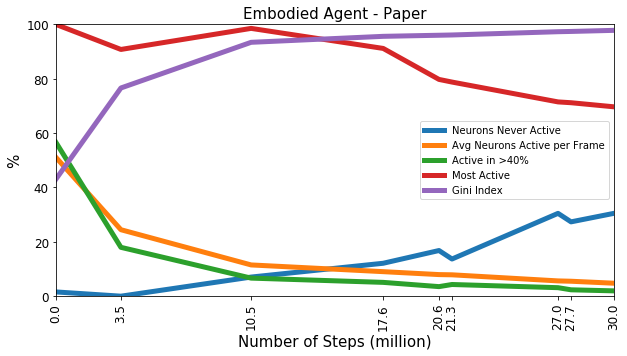

In [6]:
model_ckpts_paper = np.array(['0','350','1050','1760','2060','2130','2700','2770','3000'])
allEncPaper = encsFromCkpts(model_ckpts_paper,'../Paper/NNPaper/models/TowerF4_Baseline-0/LearningBrain/model-')
Stats_Paper = getSparsityStats(allEncPaper,model_ckpts_paper)
plotStats(Stats_Paper,'Embodied Agent - Paper')

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-50000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-100000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-150000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-200000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-250000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-40000

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-3300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-3350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-3400000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-3450000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-3500000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-3550000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-3600000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/mod

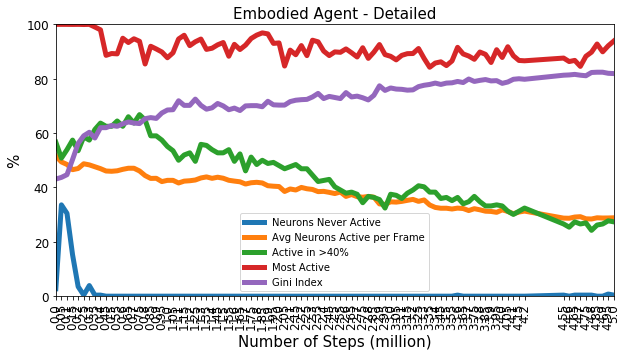

In [8]:
model_ckpts_detailed = np.array(['0','5','10','15','20','25','30','35','40','45','50','55','60','65','70','75','80','85','90','95','100',
                               '105','110','115','120','125','130','135','140','145','150','155','160','165','170','175','180',
                            '185','190','195','200','205','210','215','220','225','230','235','240','245','250','255','260',
                            '265','270','275','280','285','290','295','300','305','310','315','320','325','330','335','340',
                            '345','350','355','360','365','370','375','380','385','390','395','400','405','410','415','420',
                            '455','460','465','470','475','480','485','490','495','500'])
allEncDetailed = encsFromCkpts(model_ckpts_detailed,'../Paper/NNPaper/models/TowerF4_Baseline_Detailed-0/LearningBrain/model-')
Stats_Detailed = getSparsityStats(allEncDetailed,model_ckpts_detailed)
plotStats(Stats_Detailed,'Embodied Agent - Detailed')

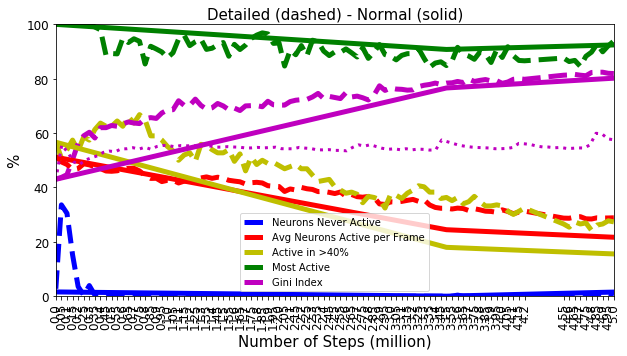

In [9]:
plotStatsBaseline(Stats_Detailed,Stats_Paper,'Detailed (dashed) - Normal (solid)')

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D2-0/LearningBrain/model-50000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D2-0/LearningBrain/model-100000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D2-0/LearningBrain/model-150000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D2-0/LearningBrain/model-200000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D2-0/LearningBrain/model-250000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D2-0/LearningBrain/model-300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D2-0/LearningBrain/model-350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D2-0/LearningBrain/model-400000.cptk
INFO:tensorflow:Restoring parameters from

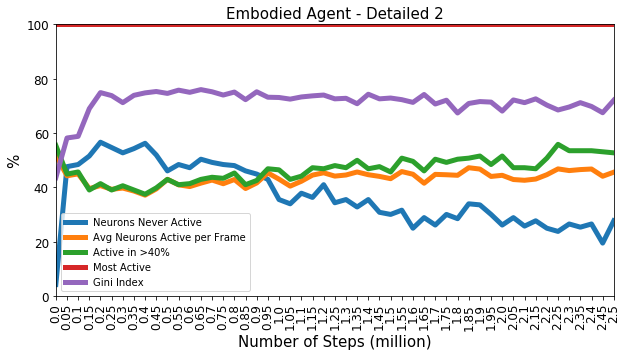

In [10]:
model_ckpts_detailed2 = np.array(['0','5','10','15','20','25','30','35','40','45','50','55','60','65','70','75','80',
                              '85','90','95','100','105','110','115','120','125','130','135','140','145','150',
                              '155','160','165','170','175','180','185','190','195','200','205','210','215','220',
                              '225','230','235','240','245','250'])
allEncDetailed2 = encsFromCkpts(model_ckpts_detailed2,'../Paper/NNPaper/models/TowerF4_Baseline_D2-0/LearningBrain/model-')
Stats_Detailed2 = getSparsityStats(allEncDetailed2,model_ckpts_detailed2)
plotStats(Stats_Detailed2,'Embodied Agent - Detailed 2')

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D3-0/LearningBrain/model-50000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D3-0/LearningBrain/model-100000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D3-0/LearningBrain/model-150000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D3-0/LearningBrain/model-200000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D3-0/LearningBrain/model-250000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D3-0/LearningBrain/model-300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D3-0/LearningBrain/model-350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D3-0/LearningBrain/model-400000.cptk
INFO:tensorflow:Restoring parameters from

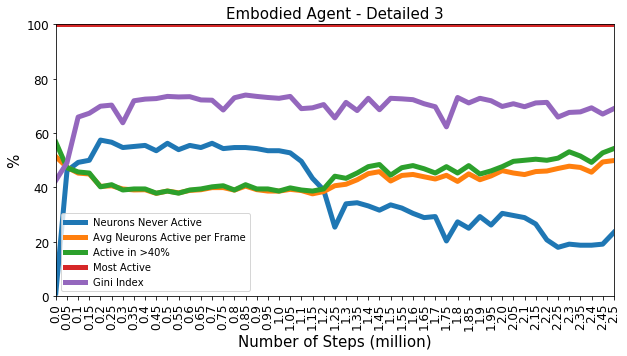

In [11]:
model_ckpts_detailed3 = np.array(['0','5','10','15','20','25','30','35','40','45','50','55','60','65','70','75','80',
                              '85','90','95','100','105','110','115','120','125','130','135','140','145','150',
                              '155','160','165','170','175','180','185','190','195','200','205','210','215','220',
                              '225','230','235','240','245','250'])
allEncDetailed3 = encsFromCkpts(model_ckpts_detailed3,'../Paper/NNPaper/models/TowerF4_Baseline_D3-0/LearningBrain/model-')
Stats_Detailed3 = getSparsityStats(allEncDetailed3,model_ckpts_detailed3)
plotStats(Stats_Detailed3,'Embodied Agent - Detailed 3')

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D4-0/LearningBrain/model-50000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D4-0/LearningBrain/model-100000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D4-0/LearningBrain/model-150000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D4-0/LearningBrain/model-200000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D4-0/LearningBrain/model-250000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D4-0/LearningBrain/model-300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D4-0/LearningBrain/model-350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D4-0/LearningBrain/model-400000.cptk
INFO:tensorflow:Restoring parameters from

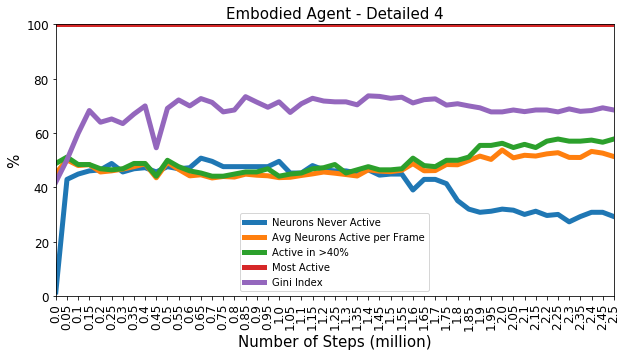

In [12]:
model_ckpts_detailed4 = np.array(['0','5','10','15','20','25','30','35','40','45','50','55','60','65','70','75','80',
                              '85','90','95','100','105','110','115','120','125','130','135','140','145','150',
                              '155','160','165','170','175','180','185','190','195','200','205','210','215','220',
                              '225','230','235','240','245','250'])
allEncDetailed4 = encsFromCkpts(model_ckpts_detailed4,'../Paper/NNPaper/models/TowerF4_Baseline_D4-0/LearningBrain/model-')
Stats_Detailed4 = getSparsityStats(allEncDetailed4,model_ckpts_detailed4)
plotStats(Stats_Detailed4,'Embodied Agent - Detailed 4')

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D5-0/LearningBrain/model-50000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D5-0/LearningBrain/model-100000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D5-0/LearningBrain/model-150000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D5-0/LearningBrain/model-200000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D5-0/LearningBrain/model-250000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D5-0/LearningBrain/model-300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D5-0/LearningBrain/model-350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_D5-0/LearningBrain/model-400000.cptk
INFO:tensorflow:Restoring parameters from

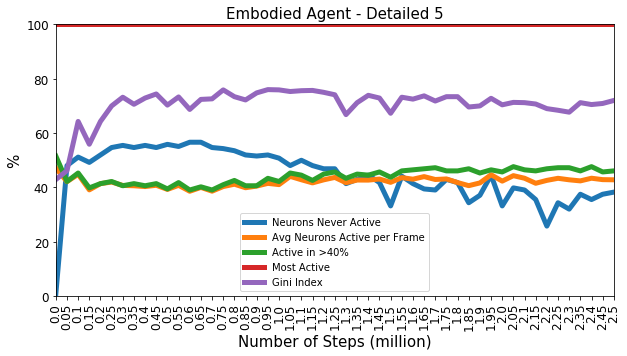

In [13]:
model_ckpts_detailed5 = np.array(['0','5','10','15','20','25','30','35','40','45','50','55','60','65','70','75','80',
                              '85','90','95','100','105','110','115','120','125','130','135','140','145','150',
                              '155','160','165','170','175','180','185','190','195','200','205','210','215','220',
                              '225','230','235','240','245','250'])
allEncDetailed5 = encsFromCkpts(model_ckpts_detailed5,'../Paper/NNPaper/models/TowerF4_Baseline_D5-0/LearningBrain/model-')
Stats_Detailed5 = getSparsityStats(allEncDetailed5,model_ckpts_detailed5)
plotStats(Stats_Detailed5,'Embodied Agent - Detailed 5')

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Supervised-0/LearningBrain/model-50000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Supervised-0/LearningBrain/model-100000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Supervised-0/LearningBrain/model-150000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Supervised-0/LearningBrain/model-200000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Supervised-0/LearningBrain/model-250000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Supervised-0/LearningBrain/model-300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Supervised-0/LearningBrain/model-350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Supervised-0/LearningBrain/model-400000.cptk
INFO:tensorflow:Restoring parameters from ../Pape

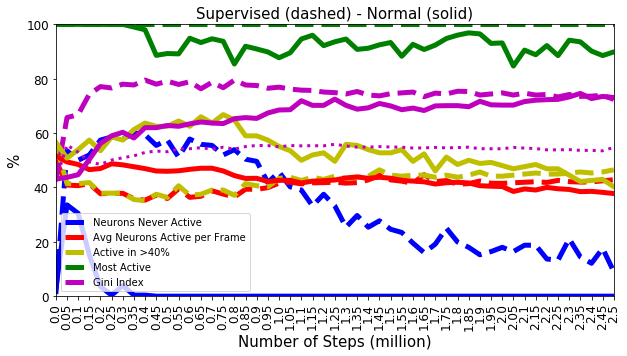

In [14]:
model_ckpts_supervised = np.array(['0','5','10','15','20','25','30','35','40','45','50','55','60','65','70','75','80',
                                   '85','90','95','100','105','110','115','120','125','130','135','140','145',
                                   '150','155','160','165','170','175','180','185','190','195','200','205',
                                   '210','215','220','225','230','235','240','245','250'])
allEncSupervised = encsFromCkpts(model_ckpts_supervised,'../Paper/NNPaper/models/TowerF4_Supervised-0/LearningBrain/model-')
Stats_Supervised = getSparsityStats(allEncSupervised,model_ckpts_supervised)
plotStatsBaseline(Stats_Supervised,Stats_Detailed,'Supervised (dashed) - Normal (solid)')

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_SupervisedNoExtR-0/LearningBrain/model-50000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_SupervisedNoExtR-0/LearningBrain/model-100000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_SupervisedNoExtR-0/LearningBrain/model-150000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_SupervisedNoExtR-0/LearningBrain/model-200000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_SupervisedNoExtR-0/LearningBrain/model-250000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_SupervisedNoExtR-0/LearningBrain/model-300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_SupervisedNoExtR-0/LearningBrain/model-350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_SupervisedNoExtR-0/LearningBrain/model-400000.cptk
I

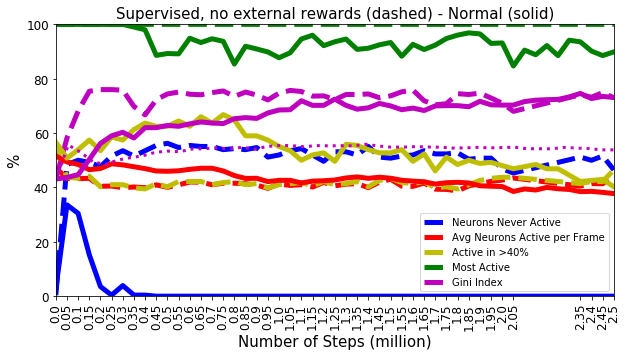

In [15]:
model_ckpts_supnoextr = np.array(['0','5','10','15','20','25','30','35','40','45','50','55',
                                  '60','65','70','75','80','85','90','95','100','105','110',
                                  '115','120','125','130','135','140','145','150','155','160',
                                  '165','170','175','180','185','190','195','200','205','235',
                                  '240','245','250'])
allEncSupNoExtR = encsFromCkpts(model_ckpts_supnoextr,'../Paper/NNPaper/models/TowerF4_SupervisedNoExtR-0/LearningBrain/model-')
Stats_SupervisedNoExtR = getSparsityStats(allEncSupNoExtR,model_ckpts_supnoextr)
plotStatsBaseline(Stats_SupervisedNoExtR,Stats_Detailed,'Supervised, no external rewards (dashed) - Normal (solid)')

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Beta0-0/LearningBrain/model-50000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Beta0-0/LearningBrain/model-100000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Beta0-0/LearningBrain/model-150000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Beta0-0/LearningBrain/model-200000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Beta0-0/LearningBrain/model-250000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Beta0-0/LearningBrain/model-300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Beta0-0/LearningBrain/model-350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_Beta0-0/LearningBrain/model-400000.cptk
INFO:tensorflow:R

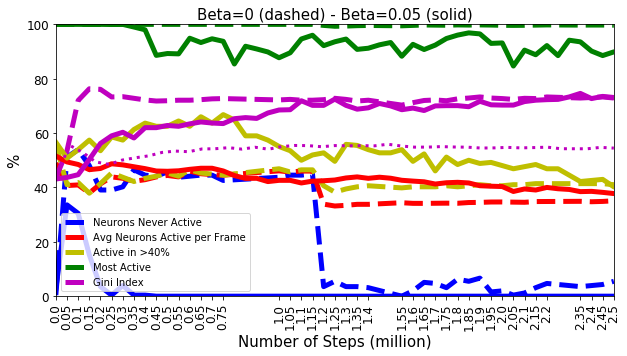

In [16]:
model_ckpts_beta0 = np.array(['0','5','10','15','20','25','30','35','40','45','50','55','60','65','70','75',
                             '100','105','110','115','120','125','130','135','140',
                              '155','160','165','170','175','180','185','190','195',
                              '200','205','210','215','220','235','240',
                              '245','250'])
allEncBeta0 = encsFromCkpts(model_ckpts_beta0,'../Paper/NNPaper/models/TowerF4_Baseline_Beta0-0/LearningBrain/model-')
Stats_Beta0 = getSparsityStats(allEncBeta0,model_ckpts_beta0)
plotStatsBaseline(Stats_Beta0,Stats_Detailed,'Beta=0 (dashed) - Beta=0.05 (solid)')

In [17]:
model_ckpts_2hidden = np.array(['0','5','10','15','20','25','30','35','40','45','50','55',
                                  '60','65','70','75','80','85','90','95','100','105','110',
                                  '115','120','125','130','135','140','145','150','155','160',
                                  '165','170','175','180','185','190','195','200','205','235',
                                  '240','245','250'])
allEnc2Hidden = encsFromCkpts(model_ckpts_2hidden,'../Paper/NNPaper/models/TowerF4_Baseline_2hiddenL-0/LearningBrain/model-')
Stats_2Hidden = getSparsityStats(allEnc2Hidden,model_ckpts_2hidden)

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_2hiddenL-0/LearningBrain/model-50000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_2hiddenL-0/LearningBrain/model-100000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_2hiddenL-0/LearningBrain/model-150000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_2hiddenL-0/LearningBrain/model-200000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_2hiddenL-0/LearningBrain/model-250000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_2hiddenL-0/LearningBrain/model-300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_2hiddenL-0/LearningBrain/model-350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_2hiddenL-0/LearningBrain/model-40000

In [18]:
model_ckpts_random = np.array(['0','5','10','15','20','25','30','35','40','45','50','55',
                                  '60','65','70','75','80','85','90','95','100','105','110',
                                  '115','120','125','130','135','140','145','150','155','160',
                                  '165','170','175','180','185','190','195','200','205','235',
                                  '240','245','250'])
allEncRandom = encsFromCkpts(model_ckpts_random,'../Paper/NNPaper/models/TowerF4_Baseline_RandP-0/LearningBrain/model-')
Stats_Random = getSparsityStats(allEncRandom,model_ckpts_random)

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_RandP-0/LearningBrain/model-50000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_RandP-0/LearningBrain/model-100000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_RandP-0/LearningBrain/model-150000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_RandP-0/LearningBrain/model-200000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_RandP-0/LearningBrain/model-250000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_RandP-0/LearningBrain/model-300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_RandP-0/LearningBrain/model-350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_RandP-0/LearningBrain/model-400000.cptk
INFO:tensorflow:R

In [19]:
model_ckpts_1floor = np.array(['0','5','10','15','20','25','30','35','40','45','50','55',
                                  '60','65','70','75','80','85','90','95','100','105','110','115','120','125','130','135','140',
                              '155','160','165','170','175','180','185','190','195',
                              '200','205','210','215','220','235','240',
                              '245','250'])
allEnc1Floor = encsFromCkpts(model_ckpts_1floor,'../Paper/NNPaper/models/TowerF4_Baseline_1Floor-0/LearningBrain/model-')
Stats_1Floor = getSparsityStats(allEnc1Floor,model_ckpts_1floor)

INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_1Floor-0/LearningBrain/model-50000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_1Floor-0/LearningBrain/model-100000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_1Floor-0/LearningBrain/model-150000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_1Floor-0/LearningBrain/model-200000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_1Floor-0/LearningBrain/model-250000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_1Floor-0/LearningBrain/model-300000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_1Floor-0/LearningBrain/model-350000.cptk
INFO:tensorflow:Restoring parameters from ../Paper/NNPaper/models/TowerF4_Baseline_1Floor-0/LearningBrain/model-400000.cptk
INFO:tens

## Paper Figures

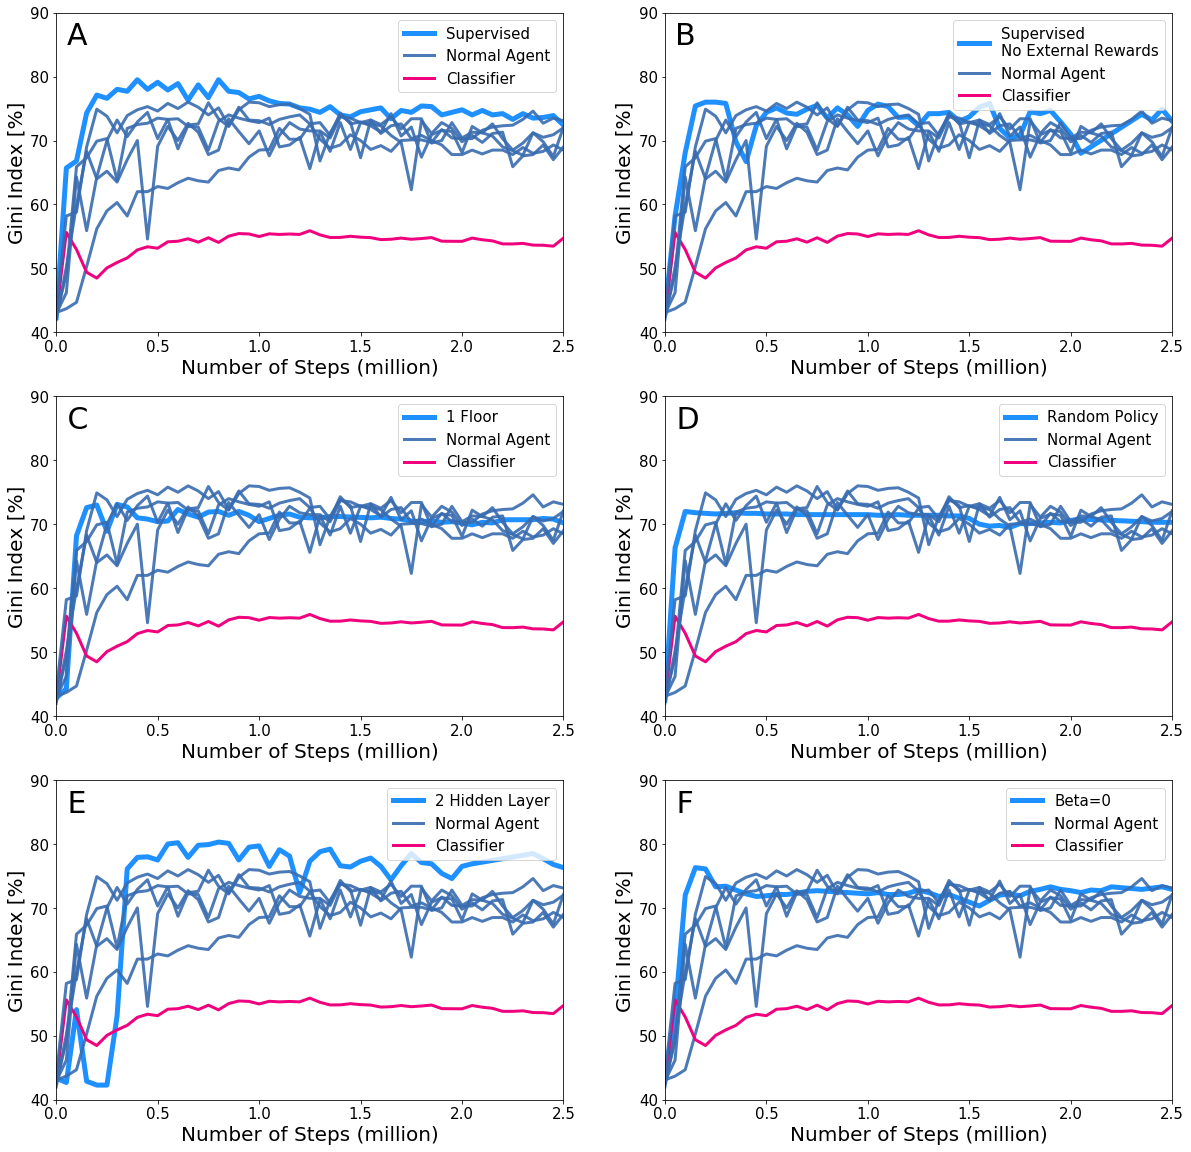

In [20]:
conditions = [Stats_Supervised,Stats_SupervisedNoExtR,Stats_1Floor,Stats_Random,Stats_2Hidden,Stats_Beta0]
cond_names = ['Supervised','Supervised\nNo External Rewards','1 Floor','Random Policy','2 Hidden Layer','Beta=0']
fig_labels = ['A','B',' C',' D',' E',' F']
plt.figure(figsize=(20,20))
for p in range(6):
    plt.subplot(3,2,p+1)
    ckptFloat, ckptLabel = ckptsToM(conditions[p]['ckpts'])
    ckptFloatB1, _ = ckptsToM(Stats_Detailed['ckpts'])
    ckptFloatB2, _ = ckptsToM(Stats_Detailed2['ckpts'])
    ckptFloatB3, _ = ckptsToM(Stats_Detailed3['ckpts'])
    ckptFloatB4, _ = ckptsToM(Stats_Detailed4['ckpts'])
    ckptFloatB5, _ = ckptsToM(Stats_Detailed5['ckpts'])
    plt.plot(ckptFloat,conditions[p]['ginis']*100,lw=5,color='dodgerblue')
    
    plt.plot(ckptFloatB1,Stats_Detailed['ginis']*100,lw=3,color=sns.color_palette("Accent", n_colors=8)[4],alpha=0.9)
    
    plt.plot(np.linspace(0,np.max(ckptFloat),51),ginisC[:51]*100,color=sns.color_palette("Accent", n_colors=8)[5],lw=3)

    plt.plot(ckptFloatB2,Stats_Detailed2['ginis']*100,lw=3,color=sns.color_palette("Accent", n_colors=8)[4],alpha=0.9)
    plt.plot(ckptFloatB3,Stats_Detailed3['ginis']*100,lw=3,color=sns.color_palette("Accent", n_colors=8)[4],alpha=0.9)
    plt.plot(ckptFloatB4,Stats_Detailed4['ginis']*100,lw=3,color=sns.color_palette("Accent", n_colors=8)[4],alpha=0.9)
    plt.plot(ckptFloatB5,Stats_Detailed5['ginis']*100,lw=3,color=sns.color_palette("Accent", n_colors=8)[4],alpha=0.9)

    plt.xlim([0,np.max(ckptFloat)])
    plt.ylim([40,90])
    plt.ylabel('Gini Index [%]',fontsize=20)
    plt.xlabel('Number of Steps (million)',fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.legend([cond_names[p],'Normal Agent','Classifier'],loc=1,fontsize=15)
    
    if p<2:
        plt.text(0.05,85,fig_labels[p],fontsize=30)
    else:
        plt.text(0.01,85,fig_labels[p],fontsize=30)

plt.show()
#plt.savefig(figure_path+'sparsityGini_Controlls.eps', bbox_inches='tight', dpi=300)
#plt.savefig(figure_path+'sparsityGini_Controlls.png', bbox_inches='tight', dpi=300)

In [137]:
np.save('ginisA.npy',Stats_Detailed['ginis'])

In [138]:
ckptFloatB1, ckptLabelB = ckptsToM(Stats_Detailed['ckpts'])
np.save('ginisASteps.npy',ckptFloatB1)